In [1]:
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
from itertools import chain, combinations

from Hypergraph_Product_Code_Construction_v3 import HGP_code, Toric3
from peeling_cluster_decoder import combined_peeling_and_cluster_decoder
from utilities import generate_erasure_pattern_index_set, generate_random_H_matrix, HGP_code, generate_random_error_index_set_with_erasure_support

In [2]:
def randomly_assign_qubits_to_photons(num_multiplexing,num_photons):
    num_qubits = num_multiplexing * num_photons
    qubits = [i for i in range(num_qubits)]
    photons = []
    
    for j in range(num_photons):
        qubits_in_photon = []
        for k in range(num_multiplexing):
            picked_qubit = random.choice(qubits)
            qubits_in_photon.append(picked_qubit)
            qubits.remove(picked_qubit)
        photons.append(qubits_in_photon)    
    return photons

In [3]:
def deterministically_assign_qubits_to_photons(num_multiplexing,num_photons):
    num_qubits = num_multiplexing * num_photons
    qubits = [i for i in range(num_qubits)]
    photons = []
    
    for j in range(num_photons):
        qubits_in_photon = []
        for k in range(num_multiplexing):
            picked_qubit = qubits[0]
            qubits_in_photon.append(picked_qubit)
            qubits.remove(picked_qubit)
        photons.append(qubits_in_photon)    
    return photons

In [4]:
def make_erasure_vec_from_ph(assignment, erasure_pattern):
    erased_qubits = []
    erasure_pattern = list(erasure_pattern)
    
    for index in erasure_pattern:
        erased_qubits  = erased_qubits + assignment[index]
    return erased_qubits

In [5]:
def get_success_prob(HGP, assignment, num_trials, num_photons, erasure_rate):
    num_success = 0
    num_failure = 0
    trials = 0
    while trials < num_trials:
        trials += 1
        try:
            errors_on_photons = generate_erasure_pattern_index_set(num_photons, erasure_rate)
            erasure_on_qubits = make_erasure_vec_from_ph(assignment = assignment, erasure_pattern = errors_on_photons)
            # print('erasure_on_qubits:')
            # print(erasure_on_qubits)
            random_pauli = generate_random_error_index_set_with_erasure_support(HGP.num_qubits, erasure_index_set = set(erasure_on_qubits),error_rate = erasure_rate)
            # print('random_pauli:')
            # print(random_pauli)
            syndrome = HGP.Hz_syn_index_set_for_X_err(random_pauli)
            result = combined_peeling_and_cluster_decoder(HGP_code=HGP,E_index_set_input=set(erasure_on_qubits),s_index_set_input=syndrome)

            if HGP.is_non_trivial_X_logical_error_index_set(result[0]) == False:
                num_success += 1
            else:
                num_failure += 1
        except:
            # print("Decoder failed to decode")
            num_failure += 1
    res_trials = [num_success, num_failure]
    # print('results:' + str(res_trials))
    return res_trials

In [6]:
def agresti_coull_intetrval(pair):
    # num trial n
    success = pair[0]
    fail = pair[1]
    rate = success / (success + fail)
    n = success + fail
    z = 2
    n_tilda = n  + z ** 2
    p_tilda = (1 / n_tilda) * (success + (z**2/2) )
    # conf_int_min = p_tilda + (z * (np.sqrt(  (p_tilda / n_tilda) * (1 - p_tilda) )))
    # conf_int_max = p_tilda - (z * (np.sqrt(  (p_tilda / n_tilda) * (1 - p_tilda) )))
    dif = (z * (np.sqrt(  (p_tilda / n_tilda) * (1 - p_tilda) )))
    # return [conf_int_min, rate, conf_int_max]
    # dif = conf_int_max - conf_int_min 
    return dif

In [7]:
def rate_and_error(results, num):
    rates = []
    errors = []
    for i in range(num):
        num_success = results[i][0]
        num_fail = results[i][1]
        rate = num_fail / (num_success + num_fail)
        rates.append(rate)
        error = agresti_coull_intetrval([num_success, num_fail])
        errors.append(error)
    return rates, errors

In [8]:
H1 = generate_random_H_matrix(total_bits=10,bit_node_deg=4,check_node_deg=5)
H2 = generate_random_H_matrix(total_bits=10,bit_node_deg=4,check_node_deg=5)
HGP = HGP_code(H1,H2)
print('HGP.num_qubits:' + str(HGP.num_qubits))
erasure_rates = [0 + 0.01 * i for i in range(50)]

dt_now = datetime.datetime.now()
print(dt_now)

random_assignment = randomly_assign_qubits_to_photons(2,40)
print('assignment:' + str(random_assignment))
res_HGP_random = []
for i in erasure_rates:
    res_trials = get_success_prob(HGP=HGP, assignment=random_assignment, num_trials = 100, num_photons = 40, erasure_rate = i)
    # print(str(i) + ':' + str(res_trials))
    res_HGP_random.append(res_trials)

dt_now = datetime.datetime.now()
print(dt_now)
    
deterministic_assignment = deterministically_assign_qubits_to_photons(2,40)
print('assignment:' + str(deterministic_assignment))
res_HGP_deterministic = []
for i in erasure_rates:
    res_trials = get_success_prob(HGP=HGP, assignment=deterministic_assignment, num_trials = 100, num_photons = 40, erasure_rate = i)
    # print(str(i) + ':' + str(res_trials))
    res_HGP_deterministic.append(res_trials)

dt_now = datetime.datetime.now()
print(dt_now)

assignment_without_qm = deterministically_assign_qubits_to_photons(1,80)
print('assignment:' + str(assignment_without_qm))
res_HGP_without_qm = []
for i in erasure_rates:
    res_trials = get_success_prob(HGP=HGP, assignment=assignment_without_qm, num_trials = 100, num_photons = 80, erasure_rate = i)
    # print(str(i) + ':' + str(res_trials))
    res_HGP_without_qm.append(res_trials)

HGP.num_qubits:164
2024-03-11 14:32:41.988339
assignment:[[20, 5], [65, 67], [78, 63], [10, 71], [2, 14], [43, 32], [8, 57], [25, 72], [69, 37], [0, 19], [23, 34], [22, 60], [44, 45], [41, 28], [62, 40], [9, 51], [13, 4], [59, 55], [50, 58], [33, 36], [16, 53], [77, 54], [64, 66], [76, 75], [31, 3], [56, 15], [61, 29], [21, 7], [26, 6], [70, 68], [35, 46], [17, 74], [48, 24], [30, 39], [1, 52], [27, 49], [73, 42], [79, 38], [12, 11], [18, 47]]
2024-03-11 14:33:02.282438
assignment:[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33], [34, 35], [36, 37], [38, 39], [40, 41], [42, 43], [44, 45], [46, 47], [48, 49], [50, 51], [52, 53], [54, 55], [56, 57], [58, 59], [60, 61], [62, 63], [64, 65], [66, 67], [68, 69], [70, 71], [72, 73], [74, 75], [76, 77], [78, 79]]
2024-03-11 14:33:22.391730
assignment:[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15]

In [9]:
print(res_HGP_random)
print('--------------')
print(res_HGP_deterministic)
print('--------------')
print(res_HGP_without_qm)

[[100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0]]
--------------
[[100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [100, 0], [10

In [10]:
rate_HGP_random, error_HGP_random = rate_and_error(res_HGP_random, 50)
rate_HGP_deterministic, error_HGP_deterministic = rate_and_error(res_HGP_deterministic, 50)
rate_HGP_without_qm, error_HGP_without_qm = rate_and_error(res_HGP_without_qm, 50)

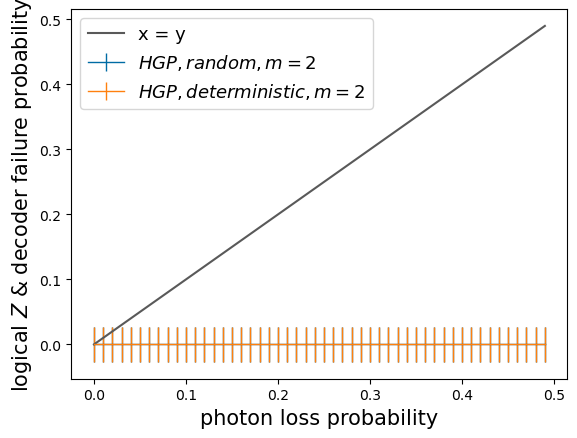

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.errorbar(erasure_rates, rate_HGP_random, error_HGP_random, label = r'$HGP, random, m=2$', color = 'C0', linewidth= 1)
ax.errorbar(erasure_rates, rate_HGP_deterministic, error_HGP_deterministic, label = r'$HGP, deterministic, m=2$', color = 'C1', linewidth= 1)
# ax.errorbar(erasure_rates, rate_HGP_without_qm, error_HGP_without_qm, label = r'$HGP, m=1$', color = 'C5', linewidth= 1)

ax.plot(erasure_rates, erasure_rates, color = 'C3', label= "x = y")
# ax.set_yscale('log')
ax.set_xlabel("photon loss probability", fontsize = 15)
ax.set_ylabel(r"logical $Z$ & decoder failure probability", fontsize = 15)
# ax.set_xlim(0.30x, 0.55)

# ax.set_title(r"$10\times 10$ toric codes", fontsize = 15)
# ax.set_facecolor('lightgrey')
plt.style.use('tableau-colorblind10')
plt.legend(loc='upper left', fontsize = 13)
# plt.savefig("10_10_multiplexed_toric_minmax.pdf")
plt.savefig("multiplexed_HGP_random.pdf")
plt.show()

In [12]:
from utilities import index_to_biindex, biindex_to_index

# A function to partion the the qubits in a code into different photons of equal size.
# Assumes a HGP code and will only assign qubits in different rows/columns together.

def HGP_different_row_and_col_assign_qubits_to_photons(num_multiplexing,num_photons,HGP_code):
    num_qubits = num_multiplexing * num_photons
    qubits = [i for i in range(num_qubits)]
    photons = []
    photons_biindex = []
    
    # Define a number to track the number of times qubits could not be selected in a different row/col.
    # In these cases, random assignment of qubit in a photon is made.
    # This is for information purposes only and does not affect the function.
    number_of_random_assignments = 0
    
    if num_qubits != HGP_code.num_qubits:
        raise Exception("The number of qubits in HGP code does not match, cannot properly assign to photons!")
        
    # Assign qubits to photons at random, checking the following conditions hold for EACH qubit in photon:
    # If qubits are from different blocks (horizontal vs vertical), no problem.
    # If qubits are from the same block, check they are in a different row and column.
    # If this condition fails, discard this qubit and try again with another selected at random.
    # If all valid assignments meeting the above conditions have been exhausted, then assign a qubit at random.
    for photon_index in range(num_photons):
        qubits_in_photon = []
        qubits_biindex_in_photon = []
        
        # Create a copy of a the original list of qubits and create a shuffled copy of it.
        # This is way, qubits can be taken at random and also exhaustively iterated through.
        shuffled_qubit_list = qubits.copy()
        random.shuffle(shuffled_qubit_list)
        
        # Set the maximum number of iterations; it's possible no remaining qubits satisfy conditions.
        max_iterations = len(shuffled_qubit_list)
        current_iteration = 0        

        for multiplex_index in range(num_multiplexing):          
            # Loop through qubits at random and try to add these to the photon, if possible meeting conditions.
            # Loop repeats a number of times equal to the multiplexing.
            while ((len(qubits_in_photon) < num_multiplexing) and (current_iteration < max_iterations)):
                current_iteration += 1
                
                # "Pop" the first element of the shuffled qubit list; shuffled ensures qubit added at random.
                # Also, popping removes the element from the list, so it is ingnored in subsequent loops.
                picked_qubit_index = shuffled_qubit_list.pop(0)

                #DEBUG
                #print("1: picked qubit index:"+str(picked_qubit_index))

                # Infer the biindex of this qubit; it depends on information from the HGP block structure.
                # There are two cases, depending on the block
                if picked_qubit_index < HGP_code.num_v_qubits:
                    # Horizontal case
                    picked_qubit_biindex = index_to_biindex(
                        index=picked_qubit_index,num_cols=HGP_code.n2,index_shift=0)
                else:
                    # Vertical case
                    picked_qubit_biindex = index_to_biindex(
                        index=picked_qubit_index,num_cols=HGP_code.r2,index_shift=HGP_code.num_v_qubits)

                # Assign if first qubit.
                if len(qubits_in_photon)==0:
                    qubits_in_photon.append(picked_qubit_index)
                    qubits_biindex_in_photon.append(picked_qubit_biindex)
                    qubits.remove(picked_qubit_index)

                else:
                    conditions_satisfied = True
                    # Iterate through each of the previously selected qubits and check they satisfy conditions.
                    for qubit_in_photon_index in range(len(qubits_in_photon)):
                        prior_qubit_index = qubits_in_photon[qubit_in_photon_index]
                        prior_qubit_biindex = qubits_biindex_in_photon[qubit_in_photon_index]

                        #DEBUG
                        #print(" 2. Comparing qubits "+str(picked_qubit_index)+" and "+str(prior_qubit_index))
                        #print("    Candidates for inclusion in photon "+str(photon_index))

                        # We only need to check the condition for qubits in the same block.
                        if (((picked_qubit_index<HGP_code.num_h_qubits) and 
                             (prior_qubit_index<HGP_code.num_h_qubits)) 
                            or ((picked_qubit_index>=HGP_code.num_h_qubits) and 
                                (prior_qubit_index>=HGP_code.num_h_qubits))):
                            # If qubits are in the same row or column, condition is not satisfied.
                            if ((picked_qubit_biindex[0]==prior_qubit_biindex[0]) or 
                                (picked_qubit_biindex[1]==prior_qubit_biindex[1])):
                                conditions_satisfied = False
                                # DEBUG
                                #print(" ---> These qubits are in same row or column of same block")
                                break

                    # Add the new qubit if it satisfies conditions on all previously selected qubits.
                    if (conditions_satisfied==True):
                        qubits_in_photon.append(picked_qubit_index)
                        qubits_biindex_in_photon.append(picked_qubit_biindex)
                        qubits.remove(picked_qubit_index)
                            
            if ((current_iteration==max_iterations) and (len(qubits_in_photon) < num_multiplexing)):
                # If all remaining qubits have been compared and none satisfy conditions, preceding loop ends.
                # In this case, default to random assignment for the remaining qubits in this photon.
                
                # DEBUG
                #print(" Photon number "+str(photon_index)+" unable to be constructed meeting conditions.")
                #print(" Instead, assigning possible remaining qubits to this photon at random.")
                
                shuffled_qubit_list = qubits.copy()
                random.shuffle(shuffled_qubit_list)
                picked_qubit_index = shuffled_qubit_list.pop()

                if picked_qubit_index < HGP_code.num_v_qubits:
                    # Horizontal case
                    picked_qubit_biindex = index_to_biindex(
                        index=picked_qubit_index,num_cols=HGP_code.n2,index_shift=0)
                else:
                    # Vertical case
                    picked_qubit_biindex = index_to_biindex(
                        index=picked_qubit_index,num_cols=HGP_code.r2,index_shift=HGP_code.num_h_qubits)
                
                qubits_in_photon.append(picked_qubit_index)
                qubits_biindex_in_photon.append(picked_qubit_biindex)
                qubits.remove(picked_qubit_index)
                
        # DEBUG
        #print("  3. Qubits in photon number "+str(photon_index)+" (index list and biindex list)")
        #print(qubits_in_photon)
        #print(qubits_biindex_in_photon)
        
        # Add the qubits in the photon to the list of photons.
        photons.append(qubits_in_photon)
        photons_biindex.append(qubits_biindex_in_photon)
        
    # DEBUG
    print("Number of times defaulted to random assignment: "+str(number_of_random_assignments))
    
    return photons, photons_biindex

In [13]:
#HGP_different_row_and_col_assign_qubits_to_photons(num_multiplexing,num_photons,HGP_code)
HGP_different_row_and_col_assign_qubits_to_photons(num_multiplexing=3,num_photons=6,HGP_code=Toric3)

Number of times defaulted to random assignment: 0


([[1, 11, 6], [12, 3, 8], [10, 0, 17], [4, 16, 9], [5, 7, 15], [13, 2, 14]],
 [[(0, 1), (0, 2), (2, 0)],
  [(1, 0), (1, 0), (2, 2)],
  [(0, 1), (0, 0), (2, 2)],
  [(1, 1), (2, 1), (0, 0)],
  [(1, 2), (2, 1), (2, 0)],
  [(1, 1), (0, 2), (1, 2)]])

In [14]:
HGP_different_row_and_col_assign_qubits_to_photons(num_multiplexing=2,num_photons=9,HGP_code=Toric3)

Number of times defaulted to random assignment: 0


([[4, 17],
  [5, 9],
  [16, 8],
  [3, 14],
  [15, 7],
  [12, 0],
  [6, 11],
  [1, 13],
  [2, 10]],
 [[(1, 1), (2, 2)],
  [(1, 2), (0, 0)],
  [(2, 1), (2, 2)],
  [(1, 0), (1, 2)],
  [(2, 0), (2, 1)],
  [(1, 0), (0, 0)],
  [(2, 0), (0, 2)],
  [(0, 1), (1, 1)],
  [(0, 2), (0, 1)]])

In [15]:
Hrep5 = np.array([[1,1,0,0,0],[0,1,1,0,0],[0,0,1,1,0],[0,0,0,1,1],[1,0,0,0,1]])
Hrep5

array([[1, 1, 0, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1],
       [1, 0, 0, 0, 1]])

In [16]:
Toric5 = HGP_code(Hrep5,Hrep5)
Toric5.num_qubits, Toric5.num_h_qubits, Toric5.num_v_qubits

(50, 25, 25)

In [17]:
HGP_different_row_and_col_assign_qubits_to_photons(num_multiplexing=2,num_photons=25,HGP_code=Toric5)

Number of times defaulted to random assignment: 0


([[49, 35],
  [36, 17],
  [25, 14],
  [44, 33],
  [2, 24],
  [21, 4],
  [47, 43],
  [41, 15],
  [12, 9],
  [8, 29],
  [31, 16],
  [1, 32],
  [6, 0],
  [46, 34],
  [26, 3],
  [22, 19],
  [11, 20],
  [27, 10],
  [40, 13],
  [38, 7],
  [45, 37],
  [5, 18],
  [30, 23],
  [28, 39],
  [42, 48]],
 [[(4, 4), (2, 0)],
  [(2, 1), (3, 2)],
  [(0, 0), (2, 4)],
  [(3, 4), (1, 3)],
  [(0, 2), (4, 4)],
  [(4, 1), (0, 4)],
  [(4, 2), (3, 3)],
  [(3, 1), (3, 0)],
  [(2, 2), (1, 4)],
  [(1, 3), (0, 4)],
  [(1, 1), (3, 1)],
  [(0, 1), (1, 2)],
  [(1, 1), (0, 0)],
  [(4, 1), (1, 4)],
  [(0, 1), (0, 3)],
  [(4, 2), (3, 4)],
  [(2, 1), (4, 0)],
  [(0, 2), (2, 0)],
  [(3, 0), (2, 3)],
  [(2, 3), (1, 2)],
  [(4, 0), (2, 2)],
  [(1, 0), (3, 3)],
  [(1, 0), (4, 3)],
  [(0, 3), (2, 4)],
  [(3, 2), (4, 3)]])

In [18]:
HGP_different_row_and_col_assign_qubits_to_photons(num_multiplexing=5,num_photons=10,HGP_code=Toric5)

Number of times defaulted to random assignment: 0


([[6, 49, 23, 17, 37],
  [31, 28, 16, 0, 47],
  [9, 15, 34, 46, 40],
  [22, 43, 32, 10, 29],
  [3, 5, 26, 21, 38],
  [30, 44, 18, 12, 1],
  [35, 27, 4, 11, 41],
  [42, 20, 33, 14, 39],
  [8, 19, 25, 48, 2],
  [24, 36, 13, 45, 7]],
 [[(1, 1), (4, 4), (4, 3), (3, 2), (2, 2)],
  [(1, 1), (0, 3), (3, 1), (0, 0), (4, 2)],
  [(1, 4), (3, 0), (1, 4), (4, 1), (3, 0)],
  [(4, 2), (3, 3), (1, 2), (2, 0), (0, 4)],
  [(0, 3), (1, 0), (0, 1), (4, 1), (2, 3)],
  [(1, 0), (3, 4), (3, 3), (2, 2), (0, 1)],
  [(2, 0), (0, 2), (0, 4), (2, 1), (3, 1)],
  [(3, 2), (4, 0), (1, 3), (2, 4), (2, 4)],
  [(1, 3), (3, 4), (0, 0), (4, 3), (0, 2)],
  [(4, 4), (2, 1), (2, 3), (4, 0), (1, 2)]])

In [19]:
HGP_different_row_and_col_assign_qubits_to_photons(num_multiplexing=10,num_photons=5,HGP_code=Toric5)

Number of times defaulted to random assignment: 0


([[28, 30, 3, 17, 5, 41, 14, 47, 21, 39],
  [4, 20, 26, 32, 49, 6, 40, 12, 38, 18],
  [9, 1, 10, 33, 46, 25, 37, 23, 44, 29],
  [48, 34, 15, 7, 35, 27, 13, 24, 42, 16],
  [22, 19, 8, 11, 45, 31, 0, 43, 2, 36]],
 [[(0, 3),
   (1, 0),
   (0, 3),
   (3, 2),
   (1, 0),
   (3, 1),
   (2, 4),
   (4, 2),
   (4, 1),
   (2, 4)],
  [(0, 4),
   (4, 0),
   (0, 1),
   (1, 2),
   (4, 4),
   (1, 1),
   (3, 0),
   (2, 2),
   (2, 3),
   (3, 3)],
  [(1, 4),
   (0, 1),
   (2, 0),
   (1, 3),
   (4, 1),
   (0, 0),
   (2, 2),
   (4, 3),
   (3, 4),
   (0, 4)],
  [(4, 3),
   (1, 4),
   (3, 0),
   (1, 2),
   (2, 0),
   (0, 2),
   (2, 3),
   (4, 4),
   (3, 2),
   (3, 1)],
  [(4, 2),
   (3, 4),
   (1, 3),
   (2, 1),
   (4, 0),
   (1, 1),
   (0, 0),
   (3, 3),
   (0, 2),
   (2, 1)]])

In [20]:
H1_test = generate_random_H_matrix(total_bits=10,bit_node_deg=4,check_node_deg=5)
H2_test = generate_random_H_matrix(total_bits=10,bit_node_deg=4,check_node_deg=5)
HGP_test = HGP_code(H1_test,H2_test.T)

In [21]:
HGP_test.num_qubits, HGP_test.num_h_qubits, HGP_test.num_v_qubits

(160, 80, 80)

In [22]:
HGP_different_row_and_col_assign_qubits_to_photons(num_multiplexing=8,num_photons=20,HGP_code=HGP_test)

Number of times defaulted to random assignment: 0


([[110, 125, 153, 4, 74, 97, 17, 141],
  [28, 94, 156, 85, 120, 149, 108, 79],
  [23, 105, 111, 60, 42, 64, 13, 146],
  [12, 56, 154, 66, 121, 88, 6, 147],
  [43, 133, 63, 78, 119, 36, 53, 18],
  [152, 61, 65, 38, 3, 90, 31, 123],
  [145, 30, 106, 139, 72, 71, 82, 1],
  [150, 33, 116, 70, 128, 132, 15, 93],
  [124, 67, 95, 50, 20, 103, 130, 0],
  [127, 113, 51, 37, 41, 159, 92, 84],
  [122, 89, 34, 144, 19, 91, 55, 115],
  [2, 49, 14, 158, 83, 77, 68, 101],
  [107, 10, 129, 73, 135, 47, 48, 5],
  [27, 100, 148, 16, 45, 76, 114, 57],
  [140, 40, 11, 29, 39, 112, 155, 96],
  [44, 117, 98, 109, 22, 134, 8, 143],
  [69, 136, 52, 26, 46, 7, 102, 151],
  [157, 35, 24, 62, 104, 9, 21, 99],
  [118, 137, 126, 32, 25, 142, 58, 81],
  [131, 87, 54, 59, 80, 138, 75, 86]],
 [[(3, 0), (4, 5), (7, 3), (0, 4), (9, 2), (1, 7), (2, 1), (6, 1)],
  [(3, 4), (1, 4), (7, 6), (0, 5), (4, 0), (6, 9), (2, 8), (9, 7)],
  [(2, 7), (2, 5), (3, 1), (7, 4), (5, 2), (8, 0), (1, 5), (6, 6)],
  [(1, 4), (7, 0), (7, 4)